In [ ]:
from file import test_complete_system
import numpy as np
from substitute_perbutate import FresnelSubstitution , PixelPerturbation
from PIL import Image
import matplotlib.pyplot as plt

In [2]:

def combined_encryption(image_path, seed_d=12345, seed_f=67890, r=3.99, x=0.5):
    """
    Combined encryption: Substitution -> Perturbation -> Inverse Perturbation -> Inverse Substitution
    
    
    Args:
        image_path: Path to the input image
        seed_d: Seed for distance parameter (substitution)
        seed_f: Seed for frequency parameter (substitution)
        r: Logistic map parameter (perturbation)
        x: Initial value for logistic map (perturbation)
        
    Returns:
        original_img, after_substitution, after_perturbation, after_inv_perturbation, final_recovered
    """
    # Load image
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    
    print(f"Original image shape: {img_array.shape}")
    height, width = img_array.shape
    
    # ==================== STEP 1: SUBSTITUTION ====================
    print("\n" + "="*60)
    print("STEP 1: SUBSTITUTION")
    print("="*60)
    
    fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
    substituted_array = np.zeros_like(img_array)
    
    print("Performing substitution...")
    for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = img_array[i, :]
        substituted_row = fs.substitute(row)
        substituted_array[i, :] = substituted_row
    
    print("✓ Substitution complete!")
    
    # ==================== STEP 2: PERTURBATION ====================
    print("\n" + "="*60)
    print("STEP 2: PERTURBATION")
    print("="*60)
    
    pp = PixelPerturbation(r_init=r, x_init=x)
    pp.x_original = x
    
    print("Performing perturbation on substituted image...")
    perturbed_array = pp.perturbate_image(substituted_array.copy())
    print("✓ Perturbation complete!")
    
    return img_array, substituted_array, perturbed_array


In [3]:
[image_array , substitued_array , perturbed_array] = combined_encryption(image_path='image.jpg')

Original image shape: (128, 128)

STEP 1: SUBSTITUTION
Performing substitution...
  Processing row 0/128
  Processing row 50/128
  Processing row 100/128
✓ Substitution complete!

STEP 2: PERTURBATION
Performing perturbation on substituted image...
✓ Perturbation complete!


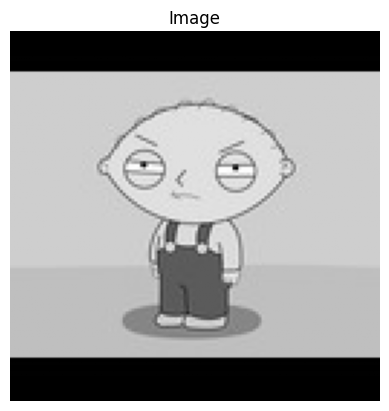

In [4]:
import matplotlib.pyplot as plt

if image_array is not None:
    plt.imshow(image_array, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.show()

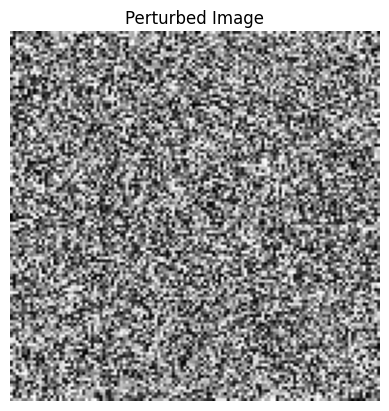

In [5]:
import matplotlib.pyplot as plt

if perturbed_array is not None:
    plt.imshow(perturbed_array, cmap='gray')
    plt.title("Perturbed Image")
    plt.axis('off')
    plt.show()

In [6]:
#perturbated array -> EDNN -> ENCRYPTED -> DDNN -> inverse perturbation -> inv subs -> decrypted img
from PIL import Image
from file import LogisticMap,EDNN,DDNN,ImageEncryptionSystem,generate_dct_matrix,load_and_prepare_image


#### get key from key_generation.py

In [7]:
from key_generation import key_gen

Key type: <class 'bytes'>
Key length: 32 bytes
Key (hex): 5e8bcec1729c0989b8d845b57a1cbd9eeb9ccda24443b4573b26f5f97eeb43ea
Feature string length: 1049552 chars


In [9]:
image = Image.open("images.jpg")
image = image.resize((256,256))
key_bytes, key_string = key_gen(image)

In [12]:
len(key_bytes)

32

#### apply aes encryption and decryption

In [ ]:
from aes import encrypt_array, decrypt_array

In [15]:
encrypted, iv, shape, dtype = encrypt_array(perturbed_array, key_bytes)

In [17]:
decrypted_array = decrypt_array(encrypted, iv, key_bytes, shape, dtype)


#### Initialize EDNN and Creating encryption/decryption system

In [21]:
layer_sizes = [4096, 9025, 10000]
logistic_params = [(0.3, 3.99), (0.4, 3.99)]

In [25]:
ednn = EDNN(layer_sizes, logistic_params)
system = ImageEncryptionSystem(ednn)

Generating 2 weight matrices...
  W_1 shape: (9025, 4096)
  W_2 shape: (10000, 9025)


#### Encrypt using EDNN

In [26]:
encrypted_vectors, encrypted_image = system.encrypt_image(perturbed_array)


Encrypting block 1/4...
Encrypting block 2/4...
Encrypting block 3/4...
Encrypting block 4/4...


#### visualize the encrypted image

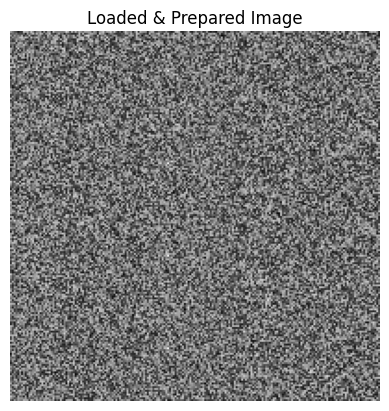

In [27]:
import matplotlib.pyplot as plt

if encrypted_image is not None:
    plt.imshow(encrypted_image, cmap='gray')
    plt.title("Loaded & Prepared Image")
    plt.axis('off')
    plt.show()


#### Decrypt

In [28]:
decrypted_image = system.decrypt_image(
        encrypted_vectors,
        gamma=1e-5,
        lambda_j=0.01,
        rho_j=1e-4,
        K=500,
        K_j=5000
    )

Decrypting block 1/4...
  Starting decryption...
    Recovering layer 2 using FISTA...
    Recovering layer 1 using AD-LPMM...
Decrypting block 2/4...
  Starting decryption...
    Recovering layer 2 using FISTA...
    Recovering layer 1 using AD-LPMM...
Decrypting block 3/4...
  Starting decryption...
    Recovering layer 2 using FISTA...
    Recovering layer 1 using AD-LPMM...
Decrypting block 4/4...
  Starting decryption...
    Recovering layer 2 using FISTA...
    Recovering layer 1 using AD-LPMM...


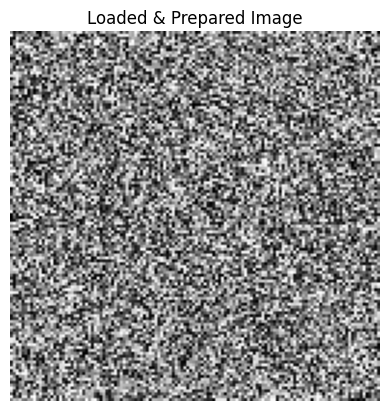

In [31]:
import matplotlib.pyplot as plt

if decrypted_image is not None:
    plt.imshow(decrypted_image, cmap='gray')
    plt.title("Loaded & Prepared Image")
    plt.axis('off')
    plt.show()


#### Check if substitution was reversed correctly

image_array -> substitued_array -> perturbed_array -> encrypted_image -> decrypted_image ->

In [66]:
diff = np.sum(np.abs(decrypted_image.astype(int) - perturbed_array.astype(int)))

In [67]:
diff

np.int64(48721)

#### INVERSE PERTURBATION

In [19]:
# parameters previously used
seed_d=12345
seed_f=67890
r=3.99
x=0.5

In [20]:
    
pp2 = PixelPerturbation(r_init=r, x_init=x)
pp2.x_original = x
    

In [21]:

inv_perturbed_array = pp2.perturbate_image_inverse(decrypted_array.copy())


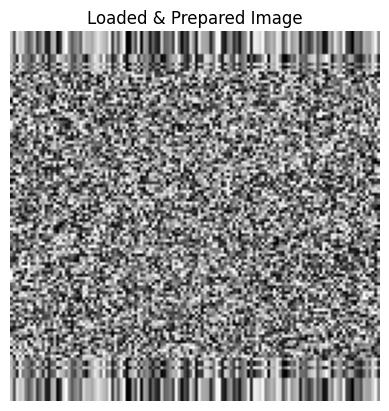

In [22]:
import matplotlib.pyplot as plt

if inv_perturbed_array is not None:
    plt.imshow(inv_perturbed_array, cmap='gray')
    plt.title("Loaded & Prepared Image")
    plt.axis('off')
    plt.show()


#### INVERSE Substitution

In [23]:
fs = FresnelSubstitution(seed_d=seed_d, seed_f=seed_f)
recovered_array = np.zeros_like(inv_perturbed_array)


In [24]:
height, width = inv_perturbed_array.shape


In [25]:
for i in range(height):
        if i % 50 == 0:
            print(f"  Processing row {i}/{height}")
        row = inv_perturbed_array[i, :]
        recovered_row = fs.substitute_inv(row)
        recovered_array[i, :] = recovered_row
    

  Processing row 0/128
  Processing row 50/128
  Processing row 100/128


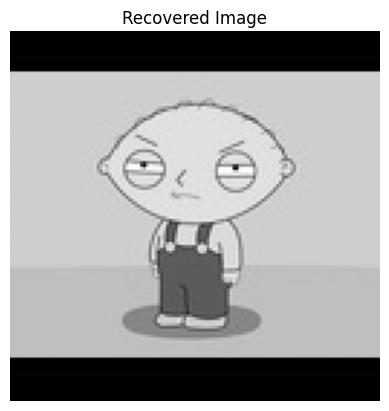

In [26]:
import matplotlib.pyplot as plt

if recovered_array is not None:
    plt.imshow(recovered_array, cmap='gray')
    plt.title("Recovered Image")
    plt.axis('off')
    plt.show()
